
### LLC4320 : Comparison Eulerian and Lagrangian basics statistics (mean velocity fields)

In [1]:
import numpy as np

import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

from xhistogram.xarray import histogram
import dask.dataframe as dd
import cartopy.crs as ccrs
import cartopy.feature as cfeature


import mitequinox.utils as ut
from mitequinox.plot import *
import mitequinox.parcels as pa
from xmitgcm import llcreader

from fsspec.implementations.local import LocalFileSystem

INFO: Compiled ParcelsRandom ==> /dev/shm/pbs.4911622.datarmor0/parcels-502090/libparcels_random_a3c55a09-2a3b-45ce-bd52-4b55c4aa58c7.so


In [2]:
from dask.distributed import Client, LocalCluster
#
#cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
cluster = PBSCluster() #processes=7, cores=7
w = cluster.scale(jobs=3)
#
client = Client(cluster)



In [3]:
client

Client Scheduler: tcp://10.148.0.129:33329 Dashboard: http://10.148.0.129:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


### Load data

In [4]:
# Lagrangian data
root_dir = '/home1/datawork/aponte/parcels/'
run_name = 'global_extra_T365j_dt1j_dij50'

p = pa.parcels_output(root_dir+run_name, parquets=['time_mean'])
df = p.df['time_mean']

df = pa.degs2ms(df) #Convert in m/s 

#df = df.persist()

In [26]:
ds_Lstats = p.load_diagnostic('L_dl1.0_stats.zarr')
ds_Lstats.load()

<xarray.Dataset>
Dimensions:                       (lat: 179, lon: 359)
Coordinates:
  * lat                           (lat) float64 -89.5 -88.5 -87.5 ... 87.5 88.5
  * lon                           (lon) float64 -179.5 -178.5 ... 177.5 178.5
Data variables: (12/13)
    area                          (lon, lat) float64 nan 49.22 ... 28.8 49.22
    meridional_velocity           (lon, lat) float64 nan nan nan ... nan nan nan
    meridional_velocity_prime     (lon, lat) float64 nan nan nan ... nan nan nan
    meridional_velocity_prime_sq  (lon, lat) float64 nan nan nan ... nan nan nan
    meridional_velocity_sq        (lon, lat) float64 nan nan nan ... nan nan nan
    velocity_amplitude            (lon, lat) float64 nan nan nan ... nan nan nan
    ...                            ...
    velocity_amplitude_prime_sq   (lon, lat) float64 nan nan nan ... nan nan nan
    velocity_amplitude_sq         (lon, lat) float64 nan nan nan ... nan nan nan
    zonal_velocity                (lon, lat) float64 nan nan nan ... nan nan nan
    zonal_velocity_prime          (lon, lat) float64 nan nan nan ... nan nan nan
    zonal_velocity_prime_sq       (lon, lat) float64 nan nan nan ... nan nan nan
    zonal_velocity_sq             (lon, lat) float64 nan nan nan ... nan nan nan
Attributes:
    dl:        1.0
    run_name:  global_extra_T365j_dt1j_dij50

In [5]:
# Eulerian data
V = ["Eta", "SSU", "SSV", "SST", "SSS"]
D = ["mean", "mean_square"]
ds = xr.merge([ut.load_diagnostic(d+"_"+v).rename({v:d+"_"+v}) 
               for v in V for d in D])

grid = xr.open_zarr('/home1/datawork/xyu/grid/mit_grid.zarr')
ds = xr.merge([ds,grid])
ds = ds.isel(i = slice(0,None,4), j = slice(0,None,4), i_g = slice(0,None,4), j_g = slice(0,None,4))
ds['lon'] = 0*ds.face+ds.XC
ds['lat'] = 0*ds.face+ds.YC
ds.load()

<xarray.Dataset>
Dimensions:          (face: 13, i: 1080, i_g: 1080, j: 1080, j_g: 1080)
Coordinates: (12/20)
  * face             (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i                (i) int64 0 4 8 12 16 20 ... 4296 4300 4304 4308 4312 4316
  * j                (j) int64 0 4 8 12 16 20 ... 4296 4300 4304 4308 4312 4316
  * i_g              (i_g) int64 0 4 8 12 16 20 ... 4300 4304 4308 4312 4316
  * j_g              (j_g) int64 0 4 8 12 16 20 ... 4300 4304 4308 4312 4316
    CS               (face, j, i) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ...               ...
    dyC              (face, j_g, i) float32 239.5 239.5 239.6 ... 324.6 324.6
    dyG              (face, j, i_g) float32 479.0 479.1 479.2 ... 324.6 324.6
    rA               (face, j, i) float32 1.555e+05 1.555e+05 ... 1.556e+05
    rAs              (face, j_g, i) float32 7.774e+04 7.776e+04 ... 1.556e+05
    rAw              (face, j, i_g) float32 1.555e+05 1.555e+05 ... 1.556e+05
    rAz              (face, j_g, i_g) float32 7.774e+04 7.776e+04 ... 1.556e+05
Data variables:
    mean_Eta         (face, j, i) float32 nan nan nan nan ... nan nan nan nan
    mean_square_Eta  (face, j, i) float32 nan nan nan nan ... nan nan nan nan
    mean_SSU         (face, j, i_g) float32 nan nan nan nan ... nan nan nan nan
    mean_square_SSU  (face, j, i_g) float32 nan nan nan nan ... nan nan nan nan
    mean_SSV         (face, j_g, i) float32 nan nan nan nan ... nan nan nan nan
    mean_square_SSV  (face, j_g, i) float32 nan nan nan nan ... nan nan nan nan
    mean_SST         (face, j, i) float32 nan nan nan nan ... nan nan nan nan
    mean_square_SST  (face, j, i) float32 nan nan nan nan ... nan nan nan nan
    mean_SSS         (face, j, i) float32 nan nan nan nan ... nan nan nan nan
    mean_square_SSS  (face, j, i) float32 nan nan nan nan ... nan nan nan nan
    lon              (face, j, i) float64 -114.9 -114.9 -114.9 ... -114.0 -114.5
    lat              (face, j, i) float64 -88.18 -88.19 -88.2 ... -88.17 -88.17

In [7]:
# Rotation velocity field
U_mean =  ds.mean_SSU.rename({'i_g': 'i'})*ds.CS - ds.mean_SSV.rename({'j_g': 'j'})*ds.SN
V_mean =  ds.mean_SSU.rename({'i_g': 'i'})*ds.SN + ds.mean_SSV.rename({'j_g': 'j'})*ds.CS

U_mean['lon'] = 0*ds.face+ds.XC
U_mean['lat'] = 0*ds.face+ds.YC

V_mean['lon'] = 0*ds.face+ds.XC
V_mean['lat'] = 0*ds.face+ds.YC

In [8]:
# Mean Eulerian field Dataset
ds_mean = xr.Dataset({'meridional_velocity_mean':V_mean,'zonal_velocity_mean':U_mean,
                      'sea_level_mean':ds.mean_Eta,'temperature_mean':ds.mean_SST,'salinity_mean':ds.mean_SSS})

In [11]:
# Binnin gof the Eulerian mean field (to compare with Lagrangian binned statisitcs)

dl = 1
lon = np.arange(-180.,180., dl)
lat = np.arange(-90., 90., dl)

N = histogram(ds_mean.lon, ds_mean.lat, bins=[lon, lat], dim=['i', 'j', 'face'], block_size=None)

In [12]:
ds_mean

<xarray.Dataset>
Dimensions:                   (face: 13, i: 1080, j: 1080)
Coordinates: (12/17)
  * face                      (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * j                         (j) int64 0 4 8 12 16 ... 4300 4304 4308 4312 4316
  * i                         (i) int64 0 4 8 12 16 ... 4300 4304 4308 4312 4316
    dxC                       (face, j, i) float32 324.6 324.6 ... 480.3 479.5
    dyG                       (face, j, i) float32 479.0 479.1 ... 324.6 324.6
    rAw                       (face, j, i) float32 1.555e+05 ... 1.556e+05
    ...                        ...
    rA                        (face, j, i) float32 1.555e+05 ... 1.556e+05
    dxG                       (face, j, i) float32 324.6 324.6 ... 480.1 479.3
    dyC                       (face, j, i) float32 239.5 239.5 ... 324.6 324.6
    rAs                       (face, j, i) float32 7.774e+04 ... 1.556e+05
    lon                       (face, j, i) float64 -114.9 -114.9 ... -114.5
    lat                       (face, j, i) float64 -88.18 -88.19 ... -88.17
Data variables:
    meridional_velocity_mean  (face, j, i) float32 nan nan nan ... nan nan nan
    zonal_velocity_mean       (face, j, i) float32 nan nan nan ... nan nan nan
    sea_level_mean            (face, j, i) float32 nan nan nan ... nan nan nan
    temperature_mean          (face, j, i) float32 nan nan nan ... nan nan nan
    salinity_mean             (face, j, i) float32 nan nan nan ... nan nan nan

NameError: name 'kwargs' is not defined

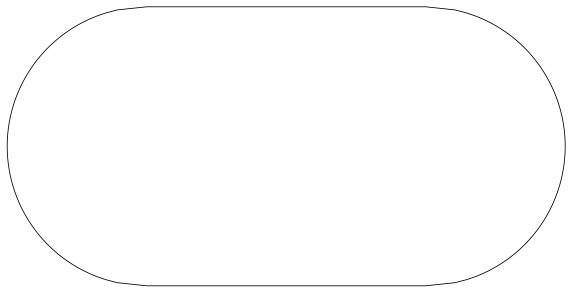

In [18]:
_faces = [0,1,2,3,4]
_projection = ccrs.EckertIII()
vmin = -0.4
vmax = 0.4
colmap='magma'
v = ds_Lstats.zonal_velocity_mean
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection=_projection)
                     
for face in _faces:
    vplt = v.sel(face=face)
    if face in [6, 7, 8, 9]:
        eps = 0.2  # found empirically
                # this deals with dateline crossing areas
        im = vplt.where(
            (vplt.XC > 0) & (vplt.XC < 180.0 - eps)
            ).plot.pcolormesh(
                    ax=ax,
                    transform=ccrs.PlateCarree(),
                    vmin=vmin,
                    vmax=vmax,
                    x="XC",
                    y="YC",
                    cmap=colmap,
                    add_colorbar=False,
                    **kwargs,
                )
        im = vplt.where(
                    (vplt.XC < 0) & (vplt.XC > -180.0 + eps)
                ).plot.pcolormesh(
                    ax=ax,
                    transform=ccrs.PlateCarree(),
                    vmin=vmin,
                    vmax=vmax,
                    x="XC",
                    y="YC",
                    cmap=colmap,
                    add_colorbar=False,
                    **kwargs,
                )
    else:
        im = vplt.plot.pcolormesh(
                    ax=ax,
                    transform=ccrs.PlateCarree(),
                    vmin=vmin,
                    vmax=vmax,
                    x="XC",
                    y="YC",
                    cmap=colmap,
                    add_colorbar=False,
                    **kwargs,
                )

In [34]:
crs = ccrs.EckertIII()
V = 'zonal_velocity'
vmax = 0.4
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection=crs)


ds_Lstats[V].plot(x='lon', 
                     y='lat',
                     vmax=vmax,
                     cmap='magma',
                     ax=ax,
                     transform=ccrs.PlateCarree(),
                    )
plt.title('Average '+V)
land_feature = cfeature.LAND
ax.add_feature(land_feature, zorder=2)

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x2aabaa3ad040> (for post_execute):


/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/110m/physical/ne_110m_land.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


URLError: <urlopen error [Errno 101] Network is unreachable>

URLError: <urlopen error [Errno 101] Network is unreachable>

<Figure size 720x720 with 2 Axes>

In [ ]:
KE = histogram(ds_mean.lon, ds_mean.lat, 
                 bins=[lon, lat], 
                 weights= (ds_mean.zonal_velocity_mean), 
                 dim=['i', 'j','face'],
                 block_size=None
                )
E_KE_mean = (E_KE/N).rename('E_KE_mean').rename({'lon_bin': 'lon','lat_bin': 'lat'})